In [115]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

np.random.seed(0)

In [135]:
class LogisticRegression():
  def __init__(self, batch_size, n_feature, type, num_class = None):
    self.batch_size = batch_size
    np.random.seed(0)

    if type == "binary":
      self.theta = np.random.uniform(size=(n_feature))
    elif type == "multi":
      self.theta = np.random.uniform(size=(n_feature, num_class))
    self.type = type
    
  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  def softmax(self, z):
    return np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)
  

  def findBinaryLossEntropy(self, y, y_hat):
    y_hat = np.clip(y_hat, 1e-6, 1 - 1e-6)
    return (- y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()
  
  def findCrossEntropyLoss(self, y, y_hat):
    y_hat = np.clip(y_hat, 1e-6, 1 - 1e-6)
    return (- y * np.log(y_hat)).mean()

  def gradient(self, X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

  def predict(self, X):
    z = np.dot(X, self.theta)
    if self.type == "binary":
      return self.sigmoid(z)
    elif self.type == "multi":
      return self.softmax(z)
  
  def loss(self, y, y_hat):
    if self.type == "binary":
      return self.findBinaryLossEntropy(y, y_hat)
    elif self.type == "multi":
      return self.findCrossEntropyLoss(y, y_hat)

  def getBatchData(self, X, y, number_batch_size, last_size, ith_batch):
    if ith_batch == number_batch_size - 1 and last_size != 0:
      X_batch = X[ith_batch * self.batch_size : (ith_batch * self.batch_size) + last_size]
      y_batch = y[ith_batch * self.batch_size : (ith_batch * self.batch_size) + last_size]
    else:
      X_batch = X[ith_batch * self.batch_size : (ith_batch + 1) * self.batch_size]
      y_batch = y[ith_batch * self.batch_size : (ith_batch + 1) * self.batch_size]

    return X_batch, y_batch
  
  def accuracy(self, y_train, y_hat):
    y_hat = np.round(y_hat)
    return (y_train == y_hat).mean()

  def fit(self, X_train, y_train, X_val, y_val, n_iters, learning_rate):
    history = {"losses_train": [], "accs_train": [], "losses_val": [], "accs_val": []}
    last_size = 0

    if len(X_train) % self.batch_size == 0:
      number_batch_size = int(len(X_train) / self.batch_size)
    else:
      number_batch_size = int(len(X_train) / self.batch_size) + 1
      last_size = len(X_train) - self.batch_size * (int(len(X_train) / self.batch_size))

    for epoch in tqdm(range(n_iters)):
      for ith_batch in range(0, number_batch_size):
        # get X_batch, y_batch
        X_train_batch, y_train_batch = self.getBatchData(X_train, y_train, number_batch_size, last_size, ith_batch)
        # predict
        y_train_batch_hat = self.predict(X_train_batch)

        # compute loss
        loss = self.loss(y_train_batch, y_train_batch_hat)

        # calculate the gradient
        gradient = self.gradient(X_train_batch, y_train_batch, y_train_batch_hat)
        
        # update theta
        self.theta -= learning_rate * gradient
        # for debug
        # calculate loss and accuracy of train sets
        history['losses_train'].append(loss)

        y_train_hat = self.predict(X_train)
        acc = self.accuracy(y_train, y_train_hat)
        history['accs_train'].append(acc)

        # calculate loss and accuracy of validation sets
        y_val_hat = self.predict(X_val)
        loss_val = self.loss(y_val, y_val_hat)
        history['losses_val'].append(loss_val)
        acc_val = self.accuracy(y_val, y_val_hat)
        history['accs_val'].append(acc_val)

      if (epoch + 1) % 10 == 0:
        print("Epoch: {}, loss: {}, acc: {}, loss_val: {}, acc_val: {}".format(epoch + 1, loss, acc, loss_val, acc_val))
    return history


# Titanic data

In [150]:
path_csv = "data/titanic_modified_dataset.csv"
titanic_data_df = pd.read_csv(path_csv, index_col="PassengerId")
titanic_data_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,0
2,1,1,38.0,1,0,71.2833,1,1,1
3,3,1,26.0,0,0,7.9250,0,2,1
4,1,1,35.0,1,0,53.1000,0,1,1
5,3,0,35.0,0,0,8.0500,0,0,0
...,...,...,...,...,...,...,...,...,...
887,2,0,27.0,0,0,13.0000,0,5,0
888,1,1,19.0,0,0,30.0000,0,2,1
889,3,1,28.0,1,2,23.4500,0,2,0


In [151]:
# convert to numpy array
titanic_data_arr = titanic_data_df.to_numpy().astype(np.float64)

# shuffle data
idx = np.arange(titanic_data_arr.shape[0])
np.random.shuffle(idx)
titanic_data_arr = titanic_data_arr[idx]

In [152]:
# devide features to X, label to y 
X, y = titanic_data_arr[:, :-1], titanic_data_arr[:, -1]
print(X.shape)
print(y.shape)

(891, 8)
(891,)


In [159]:
# add bias to X
bias = np.ones((X.shape[0], 1))
X_b = np.append(X, bias, axis=1)

TRAIN_SIZE = 0.7
VAL_SIZE = 0.2
#TEST_SIZE = 0.1
TRAIN_SAMPLES = int(TRAIN_SIZE * titanic_data_arr.shape[0])
VAL_SAMPLES = TRAIN_SAMPLES + int(VAL_SIZE * titanic_data_arr.shape[0])

x_train, y_train = X_b[:TRAIN_SAMPLES], y[:TRAIN_SAMPLES]
x_val, y_val = X_b[TRAIN_SAMPLES:VAL_SAMPLES], y[TRAIN_SAMPLES:VAL_SAMPLES]
x_test, y_test = X_b[VAL_SAMPLES:], y[VAL_SAMPLES:]

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(623, 9) (178, 9) (90, 9)
(623,) (178,) (90,)


## Training

In [162]:
n_features = x_train.shape[1]
n_iters = 100

## Batch_size = 1, learning_rate = 0.0001

In [163]:
batch_size = 1
learning_rate = 0.0001
LRModel = LogisticRegression(batch_size, n_features, type="binary")
history = LRModel.fit(x_train, y_train, x_val, y_val, n_iters, learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, loss: 3.4377027502668556, acc: 0.6982343499197432, loss_val: 0.8963363931263085, acc_val: 0.7078651685393258
Epoch: 20, loss: 2.7723812544277306, acc: 0.7174959871589085, loss_val: 0.7812198377984517, acc_val: 0.7303370786516854
Epoch: 30, loss: 2.2268843704744987, acc: 0.7335473515248796, loss_val: 0.686934723827934, acc_val: 0.7415730337078652
Epoch: 40, loss: 1.8070282423923587, acc: 0.7479935794542536, loss_val: 0.6173137120028781, acc_val: 0.7528089887640449
Epoch: 50, loss: 1.50471207041337, acc: 0.7640449438202247, loss_val: 0.572800904694826, acc_val: 0.7584269662921348
Epoch: 60, loss: 1.3011186111357496, acc: 0.7768860353130016, loss_val: 0.5482356440908756, acc_val: 0.7752808988764045
Epoch: 70, loss: 1.1709729322789046, acc: 0.7736757624398074, loss_val: 0.5358143871888937, acc_val: 0.7696629213483146
Epoch: 80, loss: 1.089849517185342, acc: 0.7881219903691814, loss_val: 0.5295448421858209, acc_val: 0.7640449438202247
Epoch: 90, loss: 1.0396470718920936, acc: 0.7

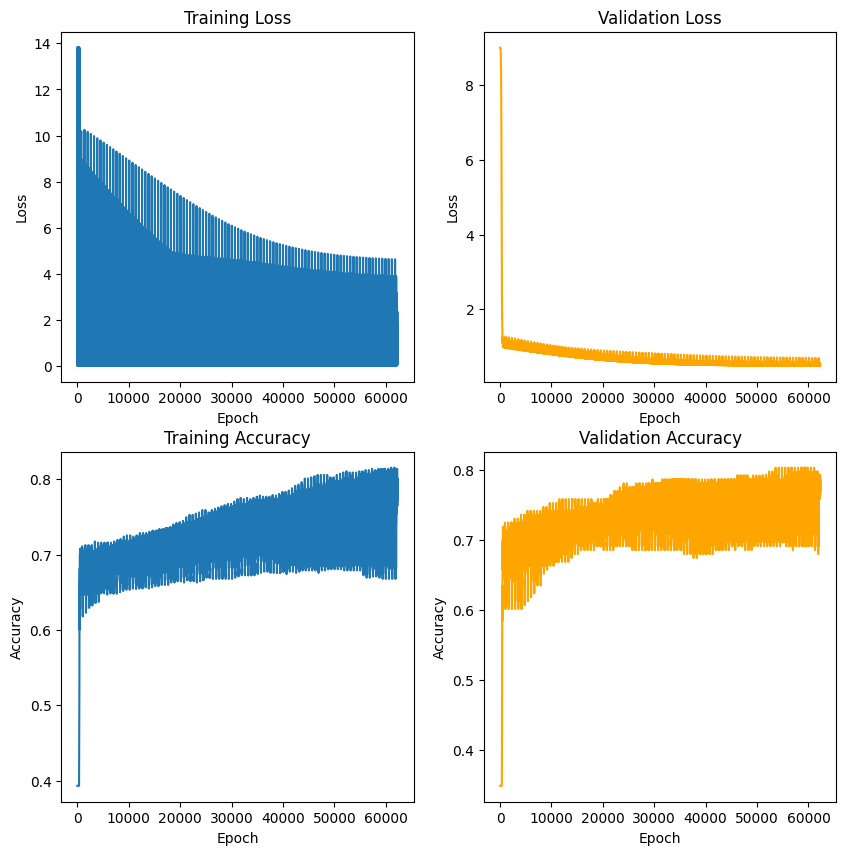

In [164]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(history["losses_train"])
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(history['losses_val'], 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(history['accs_train'])
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(history['accs_val'], 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## Batch_size = 32, learning_rate = 0.001

In [165]:
batch_size = 32
learning_rate = 0.001
LRModel = LogisticRegression(batch_size, n_features, type="binary")
history = LRModel.fit(x_train, y_train, x_val, y_val, n_iters, learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, loss: 1.5011722262468397, acc: 0.695024077046549, loss_val: 0.9927005426811878, acc_val: 0.6741573033707865
Epoch: 20, loss: 1.418362278623402, acc: 0.6982343499197432, loss_val: 0.9466634609382863, acc_val: 0.6853932584269663
Epoch: 30, loss: 1.3387544825999618, acc: 0.7062600321027287, loss_val: 0.9024954681908703, acc_val: 0.702247191011236
Epoch: 40, loss: 1.2625354763770589, acc: 0.7078651685393258, loss_val: 0.8603330628394911, acc_val: 0.7134831460674157
Epoch: 50, loss: 1.1899138238142952, acc: 0.7126805778491172, loss_val: 0.8203232679785173, acc_val: 0.7303370786516854
Epoch: 60, loss: 1.121111319922772, acc: 0.7142857142857143, loss_val: 0.7826247640589197, acc_val: 0.7303370786516854
Epoch: 70, loss: 1.0563628639764084, acc: 0.7158908507223114, loss_val: 0.7474061718092581, acc_val: 0.7415730337078652
Epoch: 80, loss: 0.9959116124209134, acc: 0.7191011235955056, loss_val: 0.7148399094671191, acc_val: 0.7415730337078652
Epoch: 90, loss: 0.9399960778239325, acc: 0.

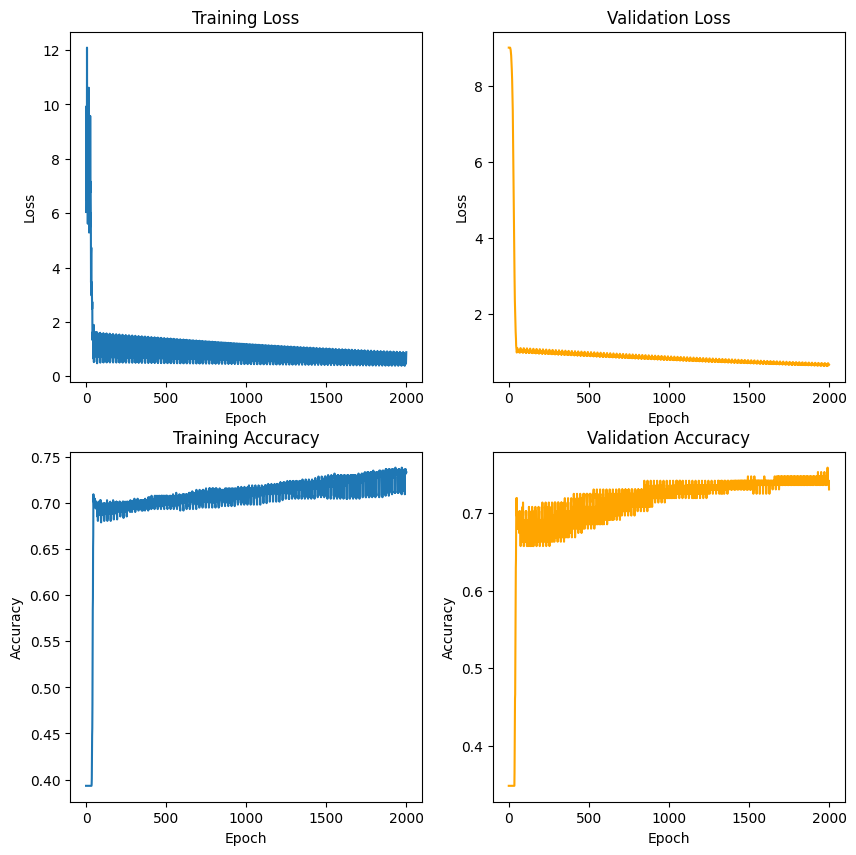

In [166]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(history["losses_train"])
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(history['losses_val'], 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(history['accs_train'])
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(history['accs_val'], 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## Batch_size = n_sample, learning_rate = 0.001

In [167]:
batch_size = len(x_train)
learning_rate = 0.001
LRModel = LogisticRegression(batch_size, n_features, type="binary")
history = LRModel.fit(x_train, y_train, x_val, y_val, n_iters, learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, loss: 8.374425519955356, acc: 0.39325842696629215, loss_val: 8.99798596366331, acc_val: 0.34831460674157305
Epoch: 20, loss: 7.966937965255063, acc: 0.39325842696629215, loss_val: 8.39714741916184, acc_val: 0.34831460674157305
Epoch: 30, loss: 5.714866232660573, acc: 0.39325842696629215, loss_val: 5.748523467032057, acc_val: 0.34831460674157305
Epoch: 40, loss: 2.075205541791117, acc: 0.47030497592295345, loss_val: 2.0981920135758134, acc_val: 0.47191011235955055
Epoch: 50, loss: 1.0662122055973602, acc: 0.7030497592295345, loss_val: 1.102731470002727, acc_val: 0.6966292134831461
Epoch: 60, loss: 1.0098018488033573, acc: 0.7062600321027287, loss_val: 1.0066286677023846, acc_val: 0.702247191011236
Epoch: 70, loss: 0.996769249258465, acc: 0.6998394863563403, loss_val: 1.0007704130938273, acc_val: 0.6910112359550562
Epoch: 80, loss: 0.9906566654804171, acc: 0.695024077046549, loss_val: 1.0024300274002675, acc_val: 0.6910112359550562
Epoch: 90, loss: 0.9870832252265932, acc: 0.6

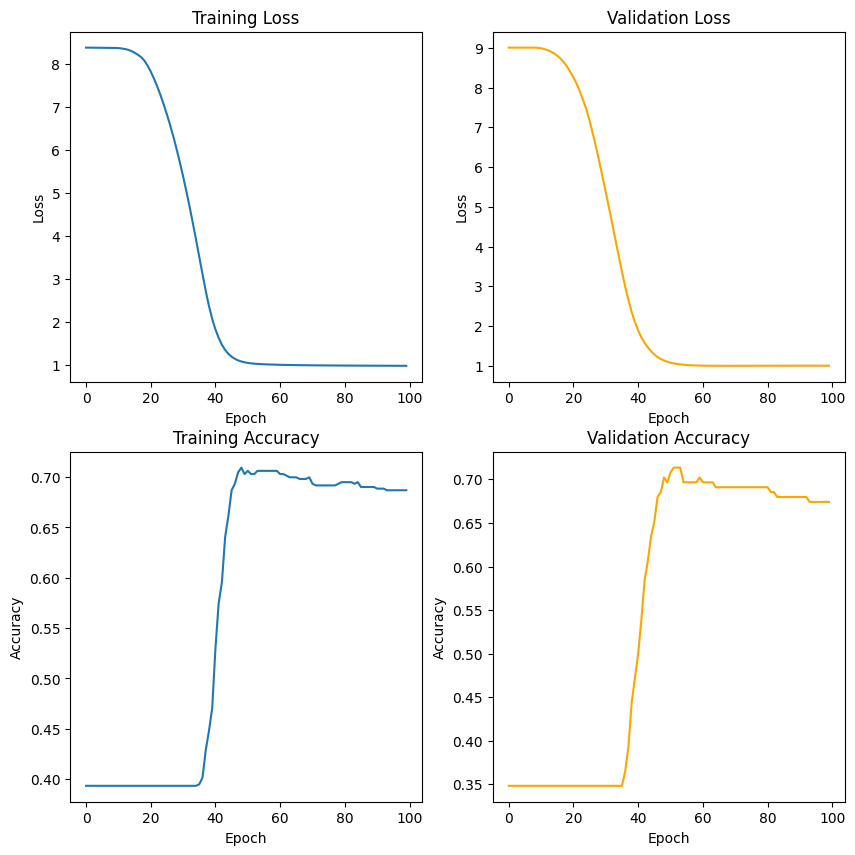

In [168]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(history["losses_train"])
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(history['losses_val'], 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(history['accs_train'])
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(history['accs_val'], 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# MNIST data

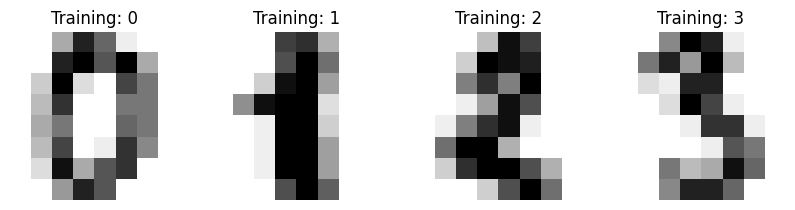

In [169]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [170]:
def one_hot(y, c):
    
    # y--> label/ground truth.
    # c--> Number of classes.
    
    # A zero matrix of size (m, c)
    y_hot = np.zeros((len(y), c))
    
    # Putting 1 for column where the label is,
    # Using multidimensional indexing.
    y_hot[np.arange(len(y)), y] = 1
    
    return y_hot

In [171]:
# flatten the images
n_samples = len(digits.images)
num_class = 10
data = digits.images.reshape((n_samples, -1))
bias = np.ones((data.shape[0], 1))
data = np.append(data, bias, axis=1)

# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.2, shuffle=True)
y_train = one_hot(y_train, num_class)
y_test = one_hot(y_test, num_class)

In [172]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1437, 65) (360, 65) (1437, 10) (360, 10)


In [173]:
batch_size = 32
learning_rate = 0.001
n_iters = 100
n_features = x_train.shape[1]
LRModel = LogisticRegression(batch_size, n_features, type='multi', num_class= num_class)
history = LRModel.fit(x_train, y_train, x_test, y_test, n_iters, learning_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, loss: 0.6583551670115735, acc: 0.8516353514265832, loss_val: 0.7390602200704093, acc_val: 0.845
Epoch: 20, loss: 0.5520379809050835, acc: 0.865205288796103, loss_val: 0.6169347732463214, acc_val: 0.8597222222222223
Epoch: 30, loss: 0.48729639252344253, acc: 0.8740431454418929, loss_val: 0.5378229483202567, acc_val: 0.8722222222222222
Epoch: 40, loss: 0.4148650757081603, acc: 0.8870563674321503, loss_val: 0.4609334898096721, acc_val: 0.8819444444444444
Epoch: 50, loss: 0.3519463734239301, acc: 0.897633959638135, loss_val: 0.39476533892477766, acc_val: 0.8936111111111111
Epoch: 60, loss: 0.2949500633010956, acc: 0.9073068893528183, loss_val: 0.34115043120975125, acc_val: 0.9038888888888889
Epoch: 70, loss: 0.25326165176007615, acc: 0.916214335421016, loss_val: 0.29961229557381747, acc_val: 0.9122222222222223
Epoch: 80, loss: 0.22224948029762728, acc: 0.92366040361865, loss_val: 0.2658028262059942, acc_val: 0.9213888888888889
Epoch: 90, loss: 0.19631473171096753, acc: 0.9313848

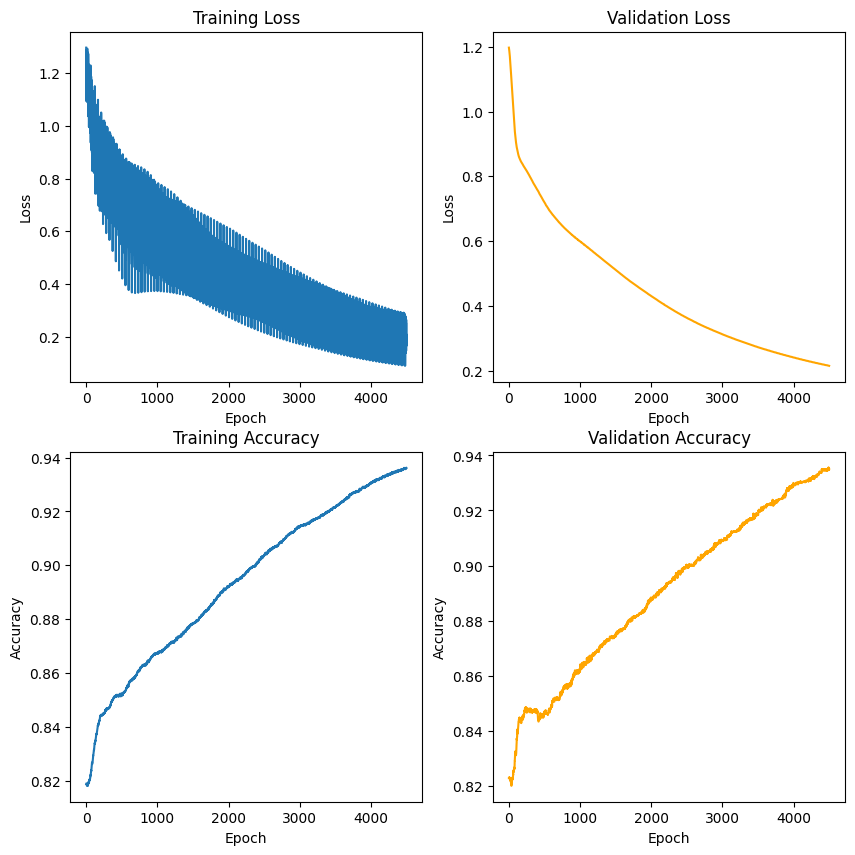

In [174]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(history["losses_train"])
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(history['losses_val'], 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(history['accs_train'])
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(history['accs_val'], 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()